# Qualifying

In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.image as image
import Fonctions as fct
import os
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

Done


In [2]:
ses = 4
race = 22

In [3]:
session = fastf1.get_session(2023,race,ses)
session.load()
fastf1.Cache.enable_cache('cache') 

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\GTR\AppData\Local\Temp\fastf1.
	Size: 502.07 MB


core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.1.5]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading da

### Pre Defined

In [4]:
# getting laps of session
laps = session.laps 

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()
laps["LapTimeS"] = laps["LapTimeS"] - 60 # correcting lap time

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# getting max lap of session
max_lap = int(session.laps["LapNumber"].max())

#results of race
results = session.results

#correcting team color
results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = session.drivers

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

# Teams list 
teams = results["TeamName"].unique()

#race name 
race_name = session.event["EventName"]
session_name = session.event["Session"+str(ses)]
sector_distance = fct.SectorDistance(laps)
sector_location = fct.SectorLocation(laps)
compoundcolor = fct.CompoundColorDf()

In [5]:
folder_path = 'C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name
if os.path.exists(folder_path):
    print("Folder exists")
else:
    os.mkdir(folder_path)

### Qualifying results 

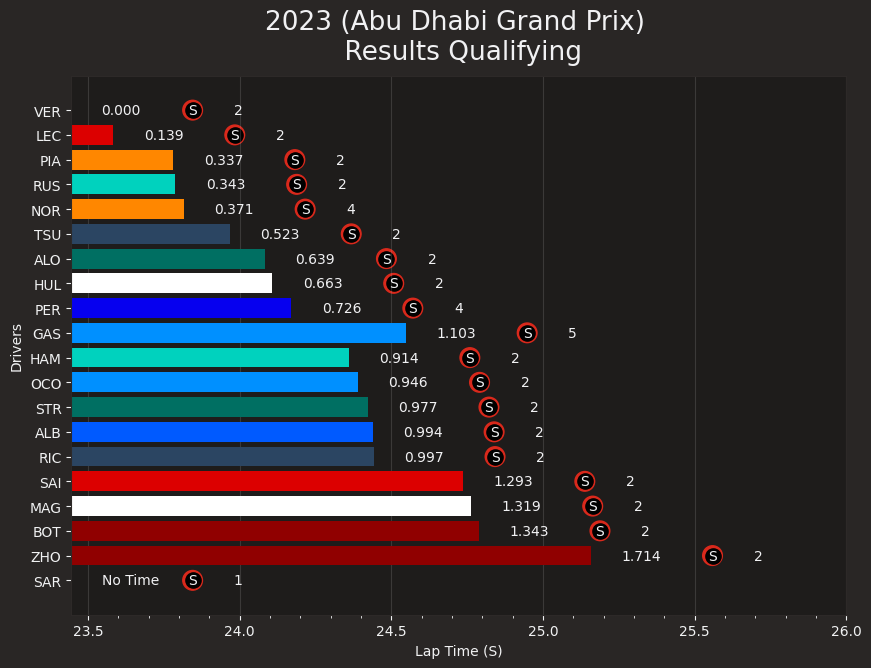

In [39]:
q1, q2, q3 = laps.split_qualifying_sessions()
q1_results = pd.DataFrame()
q2_results = pd.DataFrame()
q3_results = pd.DataFrame()
y=0
for i in drivers:
    y+=1
    if((q1.pick_driver(i).empty == False) & (y > 15)):
        if (q1.pick_driver(i).pick_fastest().isna().all()):
            lap = q1.pick_driver(i).pick_lap(q1.pick_driver(i)["LapNumber"].min()).T
        else:
            lap = q1.pick_driver(i).pick_fastest()
        q1_results = pd.concat([q1_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
    if((q2.pick_driver(i).empty == False) & (16 > y > 10)):
        if (q2.pick_driver(i).pick_fastest().isna().all()):
            lap = q2.pick_driver(i).pick_lap(q2.pick_driver(i)["LapNumber"].min()).T
        else:
            lap = q2.pick_driver(i).pick_fastest()
        q2_results = pd.concat([q2_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
    if((q3.pick_driver(i).empty == False) & (y < 11)):
        if (q3.pick_driver(i).pick_fastest().isna().all()):
            lap = q3.pick_driver(i)
            lap = lap.loc[lap["Deleted"]==False].T
            print('not time setted driver '+i)
        else:
            lap = q3.pick_driver(i).pick_fastest()
        q3_results = pd.concat([q3_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
results_qualifying = pd.concat([q3_results,q2_results,q1_results], ignore_index=True).reset_index(drop=True)
# calculate gap to P1
results_qualifying['LapTimeS'] = results_qualifying['LapTimeS'].fillna(results_qualifying["LapTimeS"].min())
results_qualifying["DeltaTime"] = results_qualifying["LapTimeS"]-results_qualifying["LapTimeS"][0]
diff = (results_qualifying.loc[results_qualifying["DeltaTime"]>7,['LapTimeS']] - results_qualifying.loc[results_qualifying["DeltaTime"]>7,['DeltaTime']].values)
results_qualifying.loc[results_qualifying["DeltaTime"]>7,['LapTimeS']] = diff
results_qualifying = pd.merge(results_qualifying, results[["DriverNumber","TeamColor"]], on='DriverNumber')
results_qualifying = pd.merge(results_qualifying, compoundcolor[["Compound","CompoundColor"]], on='Compound')


# Ploting Graph ------------------------------------

plt.figure(figsize=(10, 7))

# Load your logo image (replace 'logo.png' with the actual filename)
# logo = plt.imread('logo/LogoFomulaRcmDark.png')

y = results_qualifying["Driver"]
x = results_qualifying["LapTimeS"]
minx = results_qualifying["LapTimeS"].min()
maxx = results_qualifying["LapTimeS"].max()
color = results_qualifying["TeamColor"]
# Create the horizontal bar plot
a = 0.4
plt.barh(y,x , color = color)
plt.scatter(x+a,y , color = results_qualifying["CompoundColor"], marker='o', s=200, zorder=0)
plt.scatter(x+a,y , color = "Black", marker='o', s=120, zorder=0)

# Set labels and title
plt.xlabel('Lap Time (S)')
plt.ylabel('Drivers')
plt.title('2023 ('+session.event["EventName"]+') \n Results '+session_name)
plt.xticks(range(0, 60, 1))
plt.xlim(minx, 26)
plt.gca().invert_yaxis()
# Set the y-axis ticker to display integer values with increments of 0.1
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

plt.grid(axis='x',alpha = 0.2)


# Add text annotations near each bar
for i in range(0,len(y)):
    if ((i > 0) and (results_qualifying["DeltaTime"][i] == 0)):
        plt.text(results_qualifying["LapTimeS"][i] + 0.1, i,"No Time", va='center')       
    else:
        plt.text(results_qualifying["LapTimeS"][i] + 0.1, i, ""+"{:.3f}".format(results_qualifying["DeltaTime"][i]), va='center')
        
    
    plt.text(results_qualifying["LapTimeS"][i] + a, i,results_qualifying["Compound"][i][0], va='center', ha = 'center')
    plt.text(results_qualifying["LapTimeS"][i] + a+0.15, i,int(results_qualifying["TyreLife"][i]), va='center', ha = 'center')


# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Results_'+session_name+'.png', dpi=200, bbox_inches='tight')

plt.show()

### Fastest by sector

In [56]:
df = results_qualifying.dropna(subset = ["LapTime"])
df["Sector1Time"] = pd.to_timedelta(df["Sector1Time"])

C:\Users\GTR\AppData\Local\Temp\ipykernel_20908\149271025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sector1Time"] = pd.to_timedelta(df["Sector1Time"])


C:\Users\GTR\AppData\Local\Temp\ipykernel_20908\1625258313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_sectors["S1"] = laps_sectors["Sector1Time"].dt.total_seconds()
C:\Users\GTR\AppData\Local\Temp\ipykernel_20908\1625258313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_sectors["S2"] = laps_sectors["Sector2Time"].dt.total_seconds()
C:\Users\GTR\AppData\Local\Temp\ipykernel_20908\1625258313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

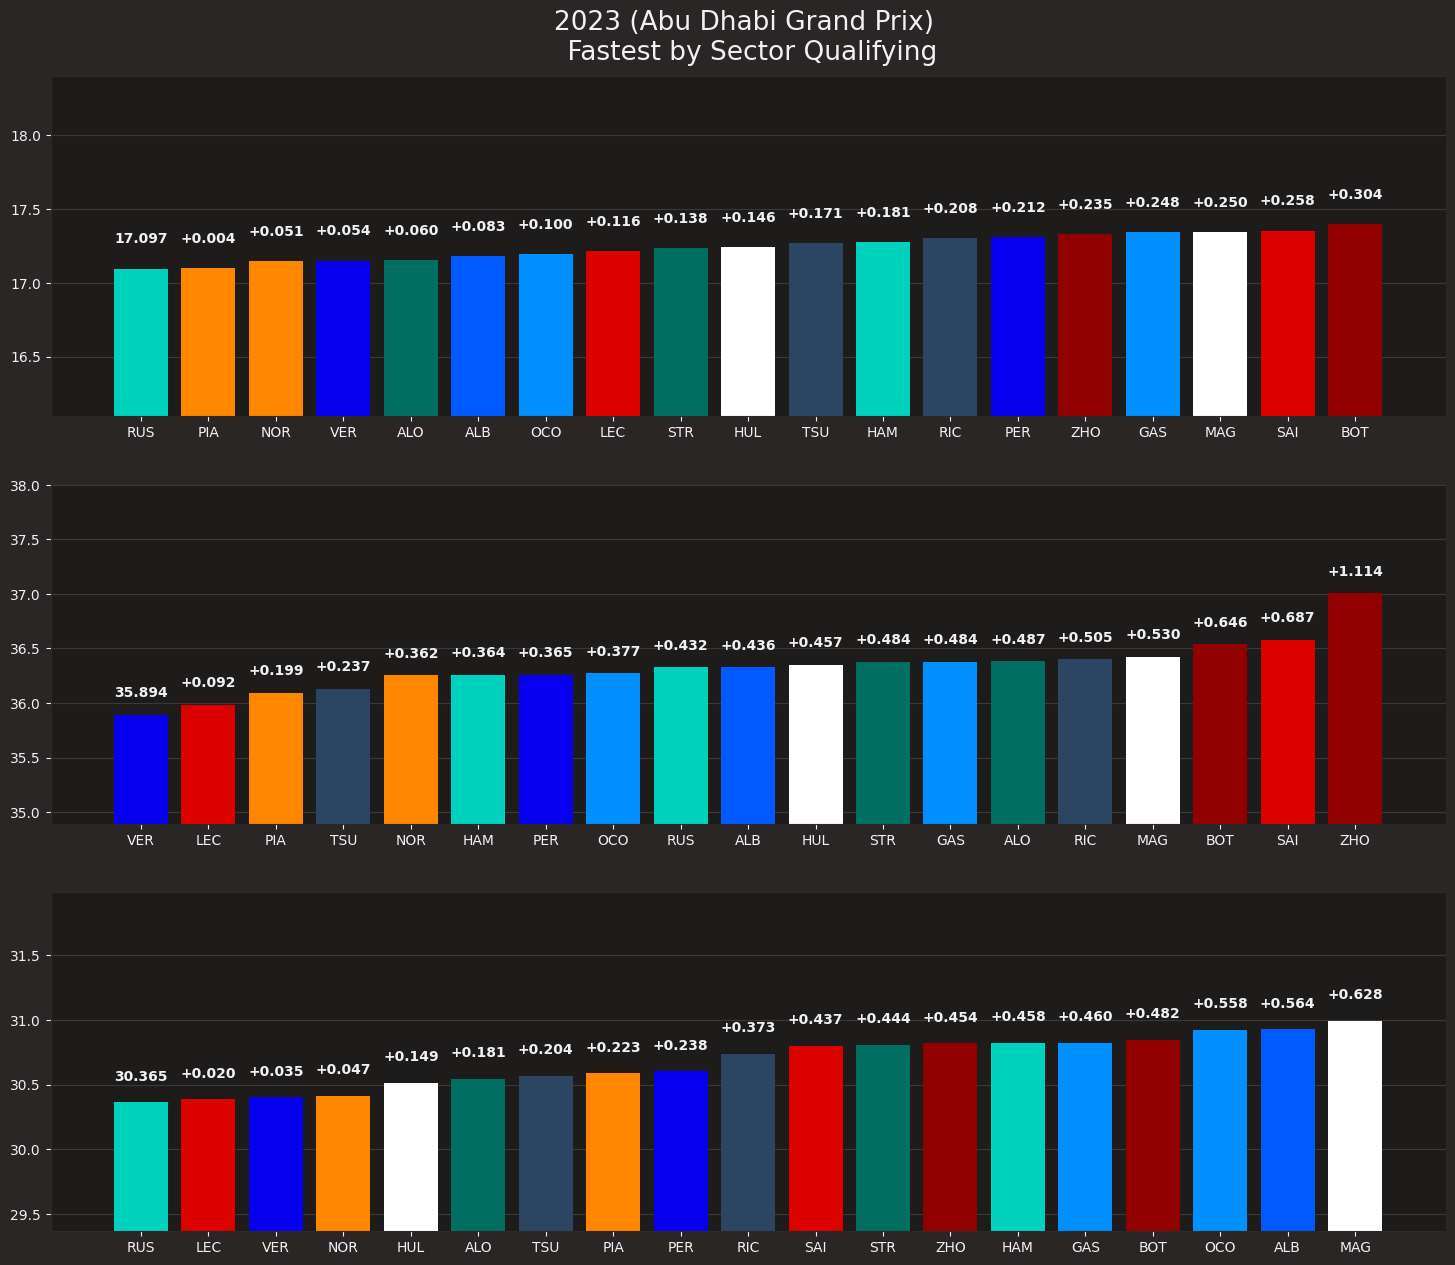

In [63]:
laps_sectors = df
fastest_sectors = pd.DataFrame()

laps_sectors["S1"] = laps_sectors["Sector1Time"].dt.total_seconds()
laps_sectors["S2"] = laps_sectors["Sector2Time"].dt.total_seconds()
laps_sectors["S3"] = laps_sectors["Sector3Time"].dt.total_seconds()

for i in drivers:
    lap = laps_sectors.loc[laps_sectors["DriverNumber"]==i]
    lap = lap[["Driver","DriverNumber","Team","LapTimeS","S1","S2","S3"]]
    fastest_sectors = pd.concat([fastest_sectors, pd.DataFrame(lap).reset_index(drop=True)], ignore_index=True)
fastest_sectors = pd.merge(fastest_sectors, results[["DriverNumber","TeamColor"]], on='DriverNumber')

fastest_sectors["GapS1"] = fastest_sectors["S1"]-fastest_sectors["S1"].min()
fastest_sectors["GapS2"] = fastest_sectors["S2"]-fastest_sectors["S2"].min()
fastest_sectors["GapS3"] = fastest_sectors["S3"]-fastest_sectors["S3"].min()
#plotting fastest sectors

fig , ax = plt.subplots(3, 1, figsize=(18, 15))

for i in range(0,3):
    fastest_sectors.sort_values(by=['S'+str(i+1)], inplace=True)
    x = fastest_sectors["Driver"]
    y = fastest_sectors["S"+str(i+1)]
    z = fastest_sectors["GapS"+str(i+1)]
    max_y = fastest_sectors["S"+str(i+1)].max()
    min_y = fastest_sectors["S"+str(i+1)].min()
    ax[i].bar(x,y, color = fastest_sectors["TeamColor"])
    ax[i].set_ylim(min_y -1, max_y+1)
    ax[i].grid(axis='y',alpha = 0.2)
    for driver in range(0,len(x)):
        if z[driver] == 0:
            ax[i].text(x[driver], y[driver] + 0.2,fct.Time3(y[driver]), ha='center', va='center', fontweight='bold')
        else:
            ax[i].text(x[driver], y[driver] + 0.2,"+"+fct.Time3(z[driver]), ha='center', va='center',rotation=0, fontweight='bold')
ax[0].set_title('2023 ('+race_name+') \n Fastest by Sector '+session_name)
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/2023_'+race_name+'_'+session_name+'_Fastest_Sectors.png', dpi=200, bbox_inches='tight')
plt.show()

### Checking Order

In [9]:
if((results_qualifying["DriverNumber"].values.tolist() == results["DriverNumber"].values.tolist())):
    results = pd.merge(results_qualifying["DriverNumber"], results, on='DriverNumber')
    print(results["DriverNumber"].values)
    # drivers list
    drivers = results["DriverNumber"].values

    # Drivers Start order 
    drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start = drivers_start["DriverNumber"].values

    #drivers abreviation
    drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

    # Drivers Start order 
    drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start_abr = drivers_start_abr["Abbreviation"].values


['1' '16' '81' '63' '4' '22' '14' '27' '11' '10' '44' '31' '18' '23' '3'
 '55' '20' '77' '24' '2']


### Top Speed Qualifying 

The DataFrame is empty driver:  2


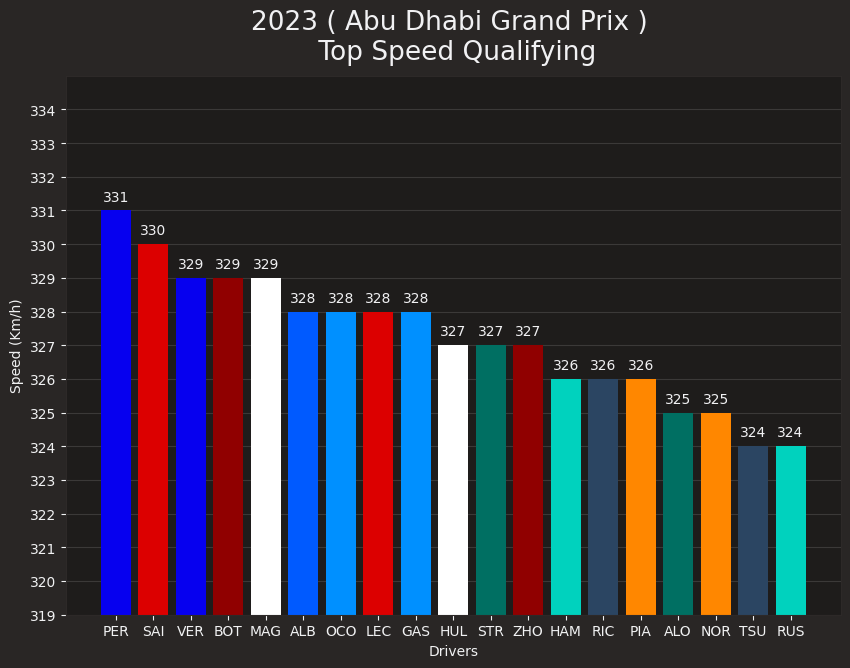

In [10]:
team_list = []
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []

for i in drivers:
    lap = laps.loc[laps["DriverNumber"]==i]
    if (lap.empty or lap["LapTime"].isna().all() or lap.pick_fastest().isna().all()):
        print("The DataFrame is empty driver: ",i)
    else:
        max_speed = lap.pick_fastest().get_car_data()
        team_list.append(session.get_driver(i)["TeamName"])
        driver_list.append(i)
        DriverAB_list.append(results.loc[results["DriverNumber"] == i,"Abbreviation"].values[0])
        top_speed_list.append(max_speed["Speed"].max())
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_top_speed = pd.DataFrame({
    'TeamName': team_list,
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'TopSpeed': top_speed_list,
    'Color': color_list
})

df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False).reset_index(drop=True)

#Plotting Qualifying Lap Time

plt.figure(figsize=(10, 7))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Top Speed '+session_name)
plt.yticks(range(int(df_top_speed["TopSpeed"].min())-20, int(df_top_speed["TopSpeed"].max())+4,1))
plt.ylim(int(df_top_speed["TopSpeed"].min())-5,int(df_top_speed["TopSpeed"].max()) +4)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2, str(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Top_Speed_'+session_name+'.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Average throttle 

The DataFrame is empty driver:  2


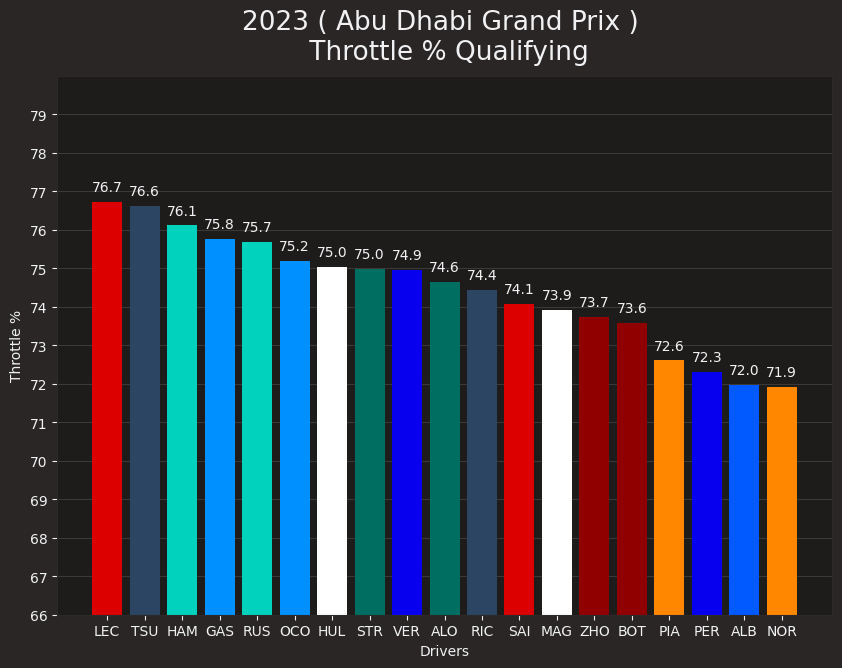

In [11]:
laps_session = laps

driver_list = []
DriverAB_list = []
throttle_list = []
color_list = []


for i in drivers:
    lap = laps_session.pick_driver(i)
    if (lap.empty or lap["LapTime"].isna().all() or lap.pick_fastest().isna().all()):
        print("The DataFrame is empty driver: ",i)
    else:
        lap = lap.pick_fastest()
        x = lap["Driver"]
        y = lap.get_car_data()['Throttle'].mean()
        driver_list.append(i)
        DriverAB_list.append(lap["Driver"])
        throttle_list.append(y)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_throttle = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'Throttle': throttle_list,
    'Color': color_list
})

#Cleaning data 

df_throttle = df_throttle.sort_values(by='Throttle', ascending=False).reset_index(drop=True)
df_throttle = df_throttle.loc[df_throttle["Throttle"]>df_throttle["Throttle"].mean()-10]

#Plotting Qualifying Lap Time

plt.figure(figsize=(10, 7))
x = df_throttle["Driver"].reset_index(drop=True)
y = df_throttle["Throttle"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_throttle["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Throttle %')
plt.title('2023 ( '+race_name+' ) \n Throttle % '+session_name)
plt.yticks(range(int(df_throttle["Throttle"].min())-20, int(df_throttle["Throttle"].max())+4,1))
plt.ylim(int(df_throttle["Throttle"].min())-5,int(df_throttle["Throttle"].max()) +4)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2,"{:.1f}".format(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Throttle_'+session_name+'.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Top Speed by team

C:\Users\GTR\AppData\Local\Temp\ipykernel_20908\3860025236.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_team_top_speed = df_top_speed.groupby(['TeamName','Color']).mean().sort_values(by='TopSpeed', ascending=False).reset_index()


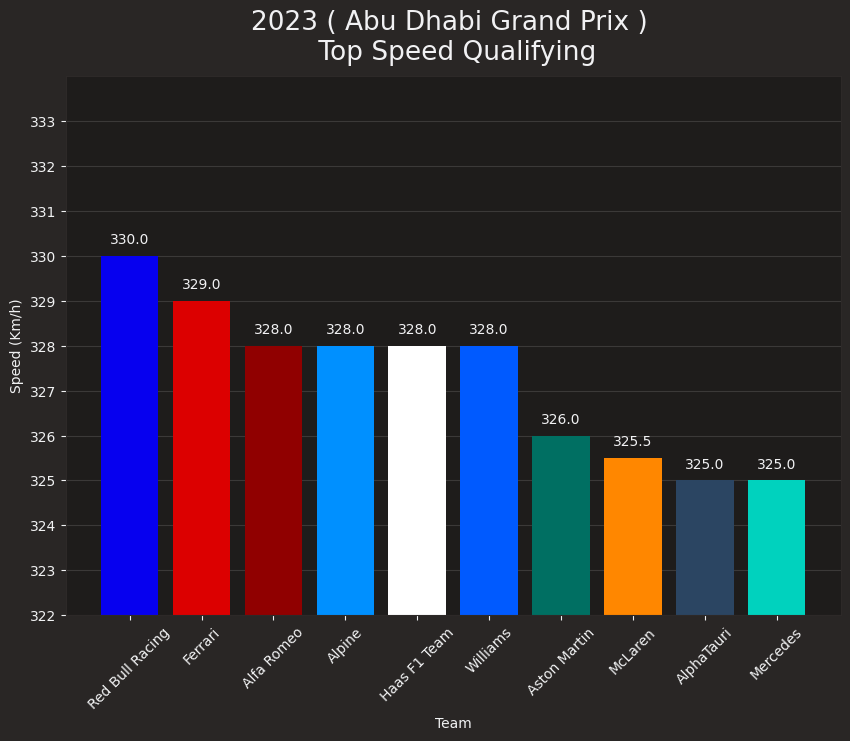

In [12]:
df_team_top_speed = df_top_speed.groupby(['TeamName','Color']).mean().sort_values(by='TopSpeed', ascending=False).reset_index()
plt.figure(figsize=(10, 7))
x = df_team_top_speed["TeamName"].reset_index(drop=True)
y = df_team_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_team_top_speed["Color"])

# Add labels and title
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Top Speed '+session_name)
plt.yticks(range(int(df_team_top_speed["TopSpeed"].min())-20, int(df_team_top_speed["TopSpeed"].max())+4,1))
plt.ylim(int(df_team_top_speed["TopSpeed"].min())-3,int(df_team_top_speed["TopSpeed"].max()) +4)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2, str(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Top_Speed_Team_'+session_name+'.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Low Speed

The DataFrame is empty


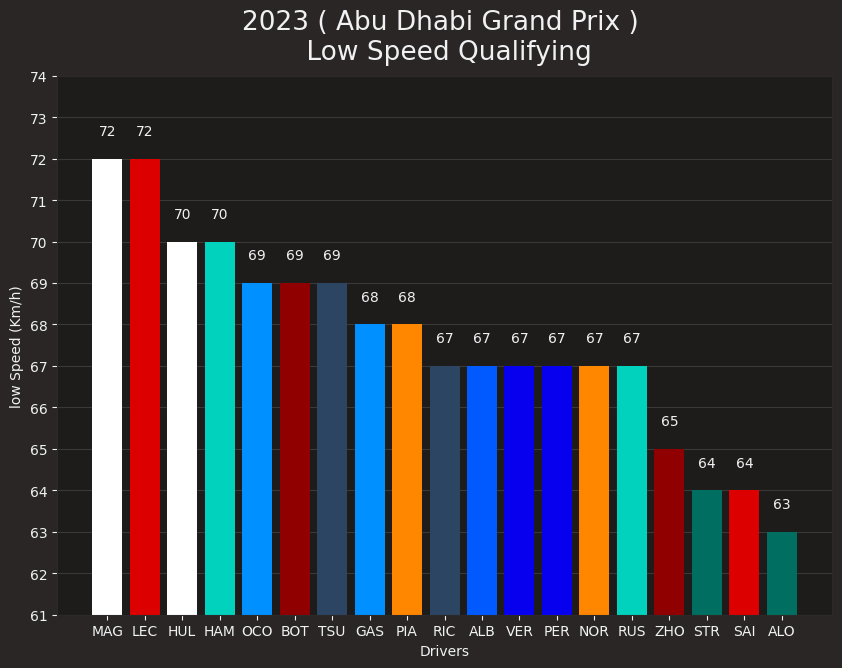

In [13]:
driver_list = []
DriverAB_list = []
low_speed_list = []
color_list = []

for i in drivers:
    lap = laps.pick_driver(i)
    if (lap.empty or lap["LapTime"].isna().all() or lap.pick_fastest().isna().all()):
        print("The DataFrame is empty")
    else:
        min_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        low_Speed = min_speed.loc[min_speed['Speed'].idxmin(),"Speed"]

        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        low_speed_list.append(low_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_low_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'lowSpeed': low_speed_list,
    'Color': color_list
})
df_low_speed = df_low_speed.sort_values(by='lowSpeed', ascending=False)
df_low_speed = df_low_speed.loc[df_low_speed["lowSpeed"]>df_low_speed["lowSpeed"].mean()-10]

# ploting the low speed

plt.figure(figsize=(10, 7))
x = df_low_speed["Driver"].reset_index(drop=True)
y = df_low_speed["lowSpeed"].reset_index(drop=True)
max = df_low_speed["lowSpeed"].max()
min = df_low_speed["lowSpeed"].min()
# Create the bar plot
plt.bar(x, y,color = df_low_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('low Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Low Speed '+session_name)
plt.yticks(range(0, 400, 1))
plt.ylim(min-2, max+2)
# Add text annotations on low of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.5, str(y.loc[i]), ha='center', va='bottom')
    
plt.grid(axis='y', alpha=0.2)
# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Low_Speed_'+session_name+'.png', dpi=200, bbox_inches='tight')
plt.show()

### Fastest Lap Average Speed

In [14]:
session.get_driver('1')["TeamName"]

'Red Bull Racing'

The DataFrame is empty


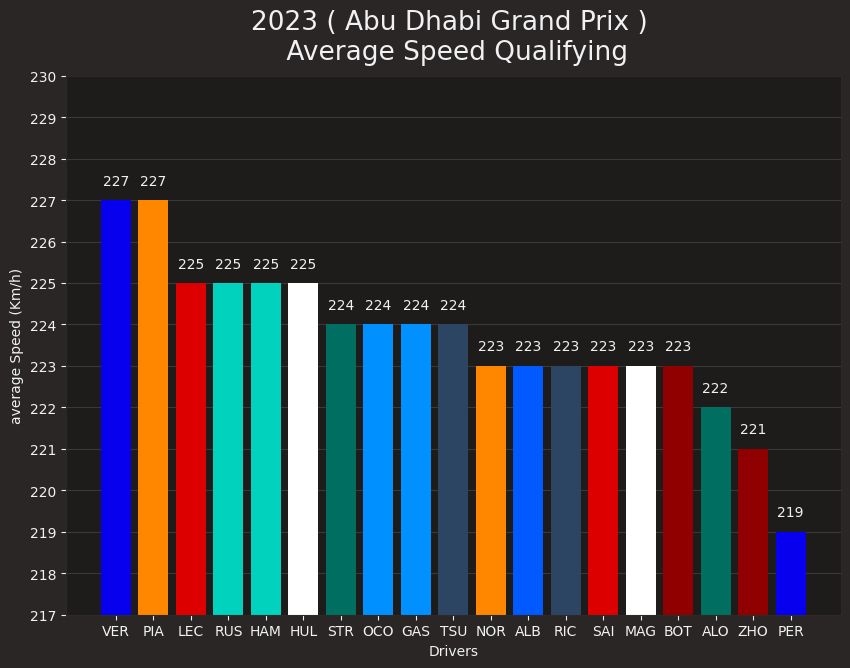

In [16]:
team_list = []
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []

for i in drivers:
    lap = laps.pick_driver(i)
    if (lap.empty or lap["LapTime"].isna().all() or lap.pick_fastest().isna().all()):
        print("The DataFrame is empty")
    else:
        
        max_speed = lap.pick_fastest().get_car_data()
        avg_Speed = round(max_speed["Speed"].mean())

        team_list.append(session.get_driver(i)["TeamName"])
        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        avg_speed_list.append(avg_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_avg_speed = pd.DataFrame({
    'TeamName': team_list,
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'AvgSpeed': avg_speed_list,
    'Color': color_list
})


df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False)
df_avg_speed = df_avg_speed.loc[df_avg_speed["AvgSpeed"]>df_avg_speed["AvgSpeed"].mean()-30]

# ploting the average speed


plt.figure(figsize=(10, 7))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Average Speed '+session_name)
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Avg_Speed_'+session_name+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

C:\Users\GTR\AppData\Local\Temp\ipykernel_20908\1907595213.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_team_avg_speed = df_avg_speed.groupby(['TeamName','Color']).mean().sort_values(by='AvgSpeed', ascending=False).reset_index()


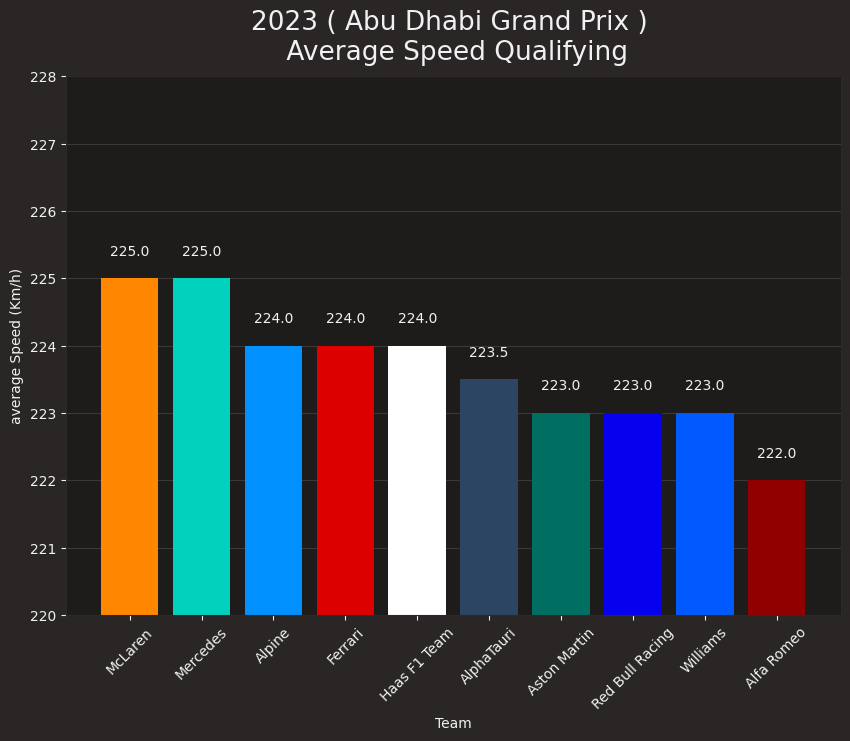

In [17]:
df_team_avg_speed = df_avg_speed.groupby(['TeamName','Color']).mean().sort_values(by='AvgSpeed', ascending=False).reset_index()
# ploting the average speed


plt.figure(figsize=(10, 7))
x = df_team_avg_speed["TeamName"].reset_index(drop=True)
y = df_team_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_team_avg_speed["Color"])

# Add labels and title
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Average Speed '+session_name)
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Avg_Speed_Team_'+session_name+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

### Efficiency

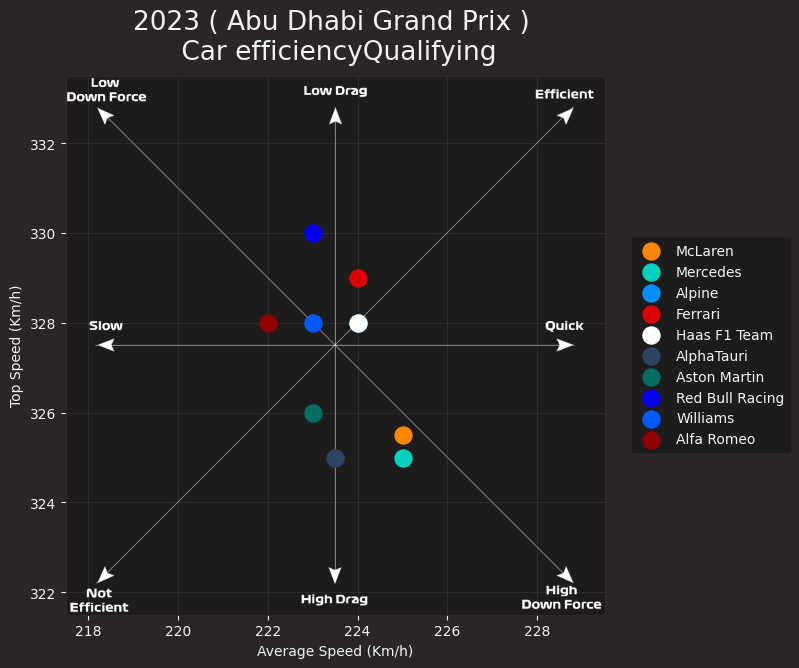

In [18]:
efficiency = pd.merge(df_team_avg_speed, df_team_top_speed[["TeamName","TopSpeed"]], on='TeamName')

x_center = (efficiency["AvgSpeed"].max() + efficiency["AvgSpeed"].min())/2
y_center = (efficiency["TopSpeed"].max() + efficiency["TopSpeed"].min())/2

plt.figure(figsize=(7, 7))
x = efficiency["AvgSpeed"].reset_index(drop=True)
y = efficiency["TopSpeed"].reset_index(drop=True)
teams = efficiency['TeamName'].values

# Create the bar plot
# plt.scatter(x, y,color = efficiency["Color"],label = ['a','b'],s=200)
# plt.axvline(x_center, color='White', linestyle='solid', linewidth=1)
# plt.axhline(y_center, color='White', linestyle='solid', linewidth=1)

for i in range(len(x)):
    plt.scatter(x[i], y[i],color = efficiency["Color"][i],label = teams[i],s=150)


# Add labels and title
plt.xlabel('Average Speed (Km/h)')
# plt.xticks(rotation=45)
plt.ylabel('Top Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Car efficiency'+session_name)
# plt.yticks(range(0, 250, 1))
# plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
# for i in range(len(x)):
#     plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

# Read the image file into a NumPy array
graph = image.imread("logo/graph effeciency02y.png")
a=6
plt.imshow(graph, extent=[x_center-a, x_center+a, y_center-a, y_center+a])

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.grid(True, alpha=0.1)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Efficiency_'+session_name+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

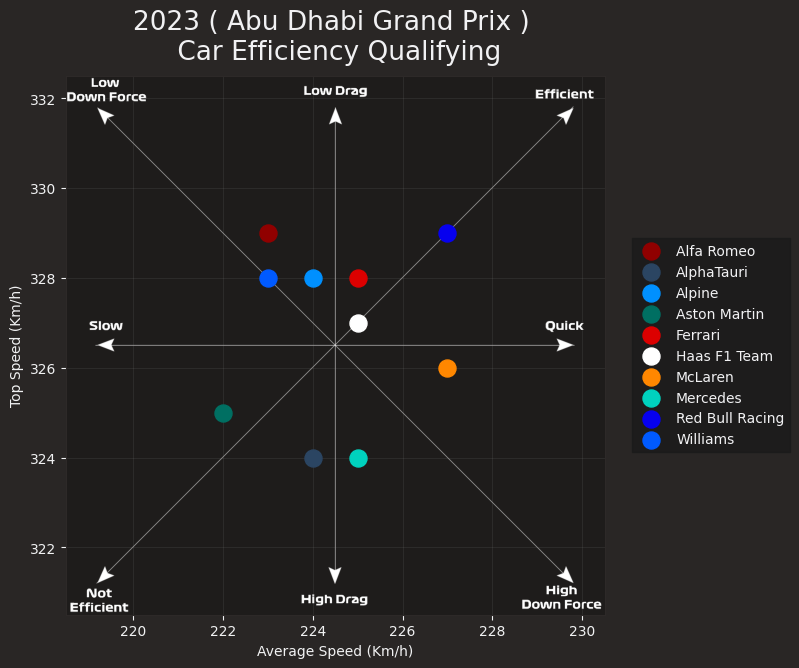

In [20]:
best_driver = results[['DriverNumber','TeamName']].copy()
best_driver['Position'] = best_driver.index + 1
best_driver.sort_values(by=['TeamName','Position'], inplace=True)
for team in best_driver['TeamName'].unique():
    if len(best_driver.loc[best_driver['TeamName']==team]) == 2:
        delete = best_driver.loc[best_driver['TeamName']==team].index.max()
        best_driver.drop(delete, inplace=True)
best_driver = pd.merge(best_driver,df_top_speed[['DriverNumber','TopSpeed']] , on='DriverNumber')
best_driver = pd.merge(best_driver,df_avg_speed[['DriverNumber','AvgSpeed','Color']] , on='DriverNumber')

x_center = (best_driver["AvgSpeed"].max() + best_driver["AvgSpeed"].min())/2
y_center = (best_driver["TopSpeed"].max() + best_driver["TopSpeed"].min())/2

plt.figure(figsize=(7, 7))
x = best_driver["AvgSpeed"].reset_index(drop=True)
y = best_driver["TopSpeed"].reset_index(drop=True)
teams = best_driver['TeamName'].values

# Create the bar plot
# plt.scatter(x, y,color = best_driver["Color"],label = ['a','b'],s=200)
# plt.axvline(x_center, color='White', linestyle='solid', linewidth=1)
# plt.axhline(y_center, color='White', linestyle='solid', linewidth=1)

for i in range(len(x)):
    plt.scatter(x[i], y[i],color = best_driver["Color"][i],label = teams[i],s=150)


# Add labels and title
plt.xlabel('Average Speed (Km/h)')
# plt.xticks(rotation=45)
plt.ylabel('Top Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Car Efficiency '+session_name)
# plt.yticks(range(0, 250, 1))
# plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
# for i in range(len(x)):
#     plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

# Read the image file into a NumPy array
graph = image.imread("logo/graph effeciency02y.png")
a=6
plt.imshow(graph, extent=[x_center-a, x_center+a, y_center-a, y_center+a])

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.grid(True, alpha=0.1)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023 '+race_name+'/Effeciency_2_'+session_name+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

### Lap time Qualifying

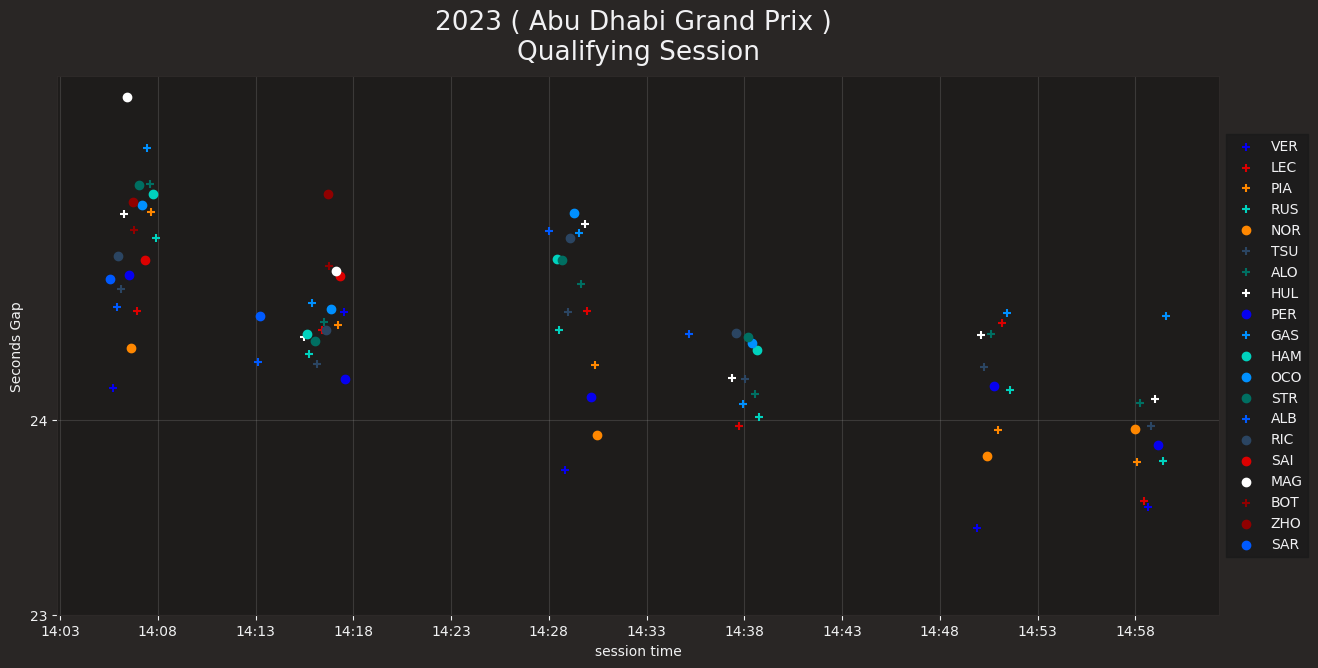

In [21]:
comp = " "
if comp == " ":
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","LapTime"]].pick_quicklaps()
else :  
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]].pick_compounds(comp).pick_quicklaps()
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapTimeS"] = laps_session["LapTimeS"] - 60
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

# plotting graph

plt.figure(figsize=(15, 7))

color_picked = []
max_lap_time = int(laps_session["LapTimeS"].max())
min_lap_time = int(laps_session["LapTimeS"].min())

for i in drivers:
    lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = session.get_driver(i)["TeamColor"]
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('2023 ( '+session.event["EventName"]+' ) \nQualifying Session')
plt.xlabel('session time')
plt.ylabel('Seconds Gap')

plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Display the plot
plt.show()


### Sectors Table

In [23]:
table_results = results_qualifying[["Driver","Sector1Time","Sector2Time","Sector3Time","LapTime","DeltaTime"]].dropna()

def highlight_min(s):
    is_min = s == s.min()
    return ['color: purple' if v else '' for v in is_min]

# Apply the styling using apply()
styled_df = table_results.style.apply(highlight_min, subset=['Sector1Time','Sector2Time','Sector3Time','LapTime'])
# Define the CSS styling for the header
header_styles = [
    {'selector': 'th',
     'props': [('background-color', 'purple'), ('color', 'white')]}
]

styled_df

,Driver,Sector1Time,Sector2Time,Sector3Time,LapTime,DeltaTime
0,VER,0 days 00:00:17.151000,0 days 00:00:35.894000,0 days 00:00:30.400000,0 days 00:01:23.445000,0.000000
1,LEC,0 days 00:00:17.213000,0 days 00:00:35.986000,0 days 00:00:30.385000,0 days 00:01:23.584000,0.139000
2,PIA,0 days 00:00:17.101000,0 days 00:00:36.093000,0 days 00:00:30.588000,0 days 00:01:23.782000,0.337000
3,RUS,0 days 00:00:17.097000,0 days 00:00:36.326000,0 days 00:00:30.365000,0 days 00:01:23.788000,0.343000
4,NOR,0 days 00:00:17.148000,0 days 00:00:36.256000,0 days 00:00:30.412000,0 days 00:01:23.816000,0.371000
5,TSU,0 days 00:00:17.268000,0 days 00:00:36.131000,0 days 00:00:30.569000,0 days 00:01:23.968000,0.523000
6,ALO,0 days 00:00:17.157000,0 days 00:00:36.381000,0 days 00:00:30.546000,0 days 00:01:24.084000,0.639000
7,HUL,0 days 00:00:17.243000,0 days 00:00:36.351000,0 days 00:00:30.514000,0 days 00:01:24.108000,0.663000
8,PER,0 days 00:00:17.309000,0 days 00:00:36.259000,0 days 00:00:30.603000,0 days 00:01:24.171000,0.726000
9,GAS,0 days 00:00:17.345000,0 days 00:00:36.378000,0 days 00:00:30.825000,0 days 00:01:24.548000,1.103000


In [65]:
q3.pick_driver("4")

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeS,LapStartTimeS,DeltaTime,S1,S2,S3
29,0 days 01:06:48.728000,NOR,4,0 days 00:01:23.816000,12.0,5.0,NaT,NaT,0 days 00:00:17.148000,0 days 00:00:36.256000,0 days 00:00:30.412000,0 days 01:05:42.060000,0 days 01:06:18.316000,0 days 01:06:48.728000,292.0,318.0,218.0,323.0,True,SOFT,4.0,False,McLaren,0 days 01:05:24.912000,2023-11-25 14:50:24.916,1,NaN,False,,False,True,23.816,3924.912,0,17.148,36.256,30.412
30,0 days 01:08:30.108000,NOR,4,0 days 00:01:41.380000,13.0,5.0,NaT,0 days 01:08:28.970000,0 days 00:00:19.659000,0 days 00:00:43.615000,0 days 00:00:38.106000,0 days 01:07:08.387000,0 days 01:07:52.002000,0 days 01:08:30.108000,260.0,232.0,NaN,208.0,False,SOFT,5.0,False,McLaren,0 days 01:06:48.728000,2023-11-25 14:51:48.732,1,NaN,False,,False,False,41.380,4008.728,0,19.659,43.615,38.106
31,0 days 01:12:57.637000,NOR,4,NaT,14.0,6.0,0 days 01:10:56.108000,NaT,NaT,0 days 00:00:46.330000,0 days 00:00:36.283000,NaT,0 days 01:12:21.419000,0 days 01:12:57.840000,123.0,247.0,227.0,227.0,False,SOFT,1.0,True,McLaren,0 days 01:08:30.108000,2023-11-25 14:53:30.112,1,NaN,False,,False,False,NaN,4110.108,0,NaN,46.330,36.283
32,0 days 01:14:21.589000,NOR,4,0 days 00:01:23.952000,15.0,6.0,NaT,NaT,0 days 00:00:17.076000,0 days 00:00:36.087000,0 days 00:00:30.789000,0 days 01:13:14.713000,0 days 01:13:50.800000,0 days 01:14:21.589000,291.0,319.0,219.0,322.0,False,SOFT,2.0,True,McLaren,0 days 01:12:57.637000,2023-11-25 14:57:57.641,1,NaN,False,,False,True,23.952,4377.637,0,17.076,36.087,30.789
33,0 days 01:16:12.346000,NOR,4,0 days 00:01:50.757000,16.0,6.0,NaT,0 days 01:16:10.446000,0 days 00:00:23.834000,0 days 00:00:47.194000,0 days 00:00:39.729000,0 days 01:14:45.423000,0 days 01:15:32.617000,0 days 01:16:12.346000,258.0,244.0,NaN,200.0,False,SOFT,3.0,True,McLaren,0 days 01:14:21.589000,2023-11-25 14:59:21.593,1,NaN,False,,False,False,50.757,4461.589,0,23.834,47.194,39.729
